In [37]:
# For importing utils
import sys
sys.path.append("..")

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from utils import PERTURBATIONS

In [ ]:
# def plot_geometric_mean_perplexities(ax_i, ax, file_info, title, checkpoints, seeds, pos_encodings, warmup, csv_path =None ):
    
#     nps = "" if pos_encodings else "_no_positional_encodings"
#     wp = "_warmup" if warmup else ""

#     results_path = '/home/s2678328/'+'perplexity_results{}/{}_100M{}/randinit_seed{}_test_{}.csv'

#     for file_data in file_info:
#         model_perturb, test_perturb, marker, linestyle, legend_name = file_data

#         all_seeds_gmeans = []
#         for seed in seeds:
#             df = pd.read_csv(results_path.format(wp, model_perturb, nps, seed, test_perturb))
#             # display(df)
#             gmeans = []

#             # Calculate geometric means for each checkpoint
#             for ckpt in checkpoints:
#                 gmeans.append(stats.gmean(df[f"Perplexities (ckpt {ckpt})"]))

#             all_seeds_gmeans.append(gmeans)

#         all_seeds_gmeans = np.array(all_seeds_gmeans)
#         means = np.mean(all_seeds_gmeans, axis=0)

#         ci = None
#         if len(seeds) > 1:
#             sems = stats.sem(all_seeds_gmeans, axis=0)
#             # Calculate confidence interval using t-distribution
#             ci_lower, ci_upper = stats.t.interval(0.95, df=len(seeds)-1,
#                                                 loc=means, scale=sems)
#             ci = (ci_upper - ci_lower) / 2

#         # Plotting
#         ax.errorbar(checkpoints, means, ci, marker=marker, 
#                     color=PERTURBATIONS[test_perturb]["color"],
#                     linestyle=linestyle, label=legend_name)

#     ax.set_title(title)
#     if ax_i == 0:
#         ax.set_ylabel("Geometric Mean Perplexity", fontsize=12)
    
#     if not pos_encodings and title == "*Shuffle":
#         ax.legend(fontsize=6)
#     elif title == "*Shuffle":
#         ax.legend(fontsize=8, framealpha=1)
#     else:
#         ax.legend(fontsize=9, framealpha=1)
#     ax.grid(True, color="lightgray")

In [47]:

def plot_geometric_mean_perplexities(ax_i, ax, file_info, title, checkpoints, seeds, pos_encodings, warmup, csv_path=None):
    nps = "" if pos_encodings else "_no_positional_encodings"
    wp = "_warmup" if warmup else ""

    results_path_template = '/home/s2678328/perplexity_results{}/{}_100M{}/randinit_seed{}_test_{}.csv'

    for model_perturb, test_perturb, marker, linestyle, legend_name in file_info:
        all_seeds_gmeans = []

        for seed in seeds:
            # Determine the actual file path
            if csv_path:
                file_path = csv_path
            else:
                file_path = results_path_template.format(wp, model_perturb, nps, seed, test_perturb)

            # Read CSV
            try:
                df = pd.read_csv(file_path)
            except Exception as e:
                print(f"❌ Failed to read {file_path}: {e}")
                continue

            df.columns = df.columns.str.strip()  # remove whitespace from column names

            gmeans = []

            for ckpt in checkpoints:
                # Try to find the correct column via regex
                pattern = re.compile(rf'Perplexities\s*\(ckpt\s*{ckpt}\)', re.IGNORECASE)
                match_col = next((col for col in df.columns if pattern.fullmatch(col)), None)

                if match_col is None:
                    print(f"⚠️ Checkpoint {ckpt} not found in file {file_path}")
                    gmeans.append(np.nan)
                    continue

                values = pd.to_numeric(df[match_col], errors='coerce')
                values = values[values > 0]  # Only positive values

                if len(values) == 0:
                    gmeans.append(np.nan)
                else:
                    gmeans.append(stats.gmean(values))

            all_seeds_gmeans.append(gmeans)

        all_seeds_gmeans = np.array(all_seeds_gmeans)
        means = np.nanmean(all_seeds_gmeans, axis=0)

        ci = None
        if len(seeds) > 1:
            sems = stats.sem(all_seeds_gmeans, axis=0, nan_policy='omit')
            ci_lower, ci_upper = stats.t.interval(0.95, df=len(seeds)-1,
                                                  loc=means, scale=sems)
            ci = (ci_upper - ci_lower) / 2

        ax.errorbar(checkpoints, means, ci, marker=marker,
                    color=PERTURBATIONS[test_perturb]["color"],
                    linestyle=linestyle, label=legend_name)

    ax.set_title(title)
    if ax_i == 0:
        ax.set_ylabel("Geometric Mean Perplexity", fontsize=12)

    if not pos_encodings and title == "*Shuffle":
        ax.legend(fontsize=6)
    elif title == "*Shuffle":
        ax.legend(fontsize=8, framealpha=1)
    else:
        ax.legend(fontsize=9, framealpha=1)

    ax.grid(True, color="lightgray")

In [ ]:
# def plot_perplexities_grouped(file_infos, titles, checkpoints, seeds, pos_encodings=True, warmup=False):
    
#     # Create a figure with multiple subplots
#     fig, axs = plt.subplots(1, len(file_infos), figsize=(16, 5), sharey=False, sharex=True)
#     fig.subplots_adjust(wspace=0.15)
#     fig.supxlabel("Training Steps", fontsize=12)
    
#     axs_flat = axs.flatten()
    
#     # Call individual plot function with different parameters for each subplot
#     for i, (file_info, title) in enumerate(zip(file_infos, titles)):
#         plot_geometric_mean_perplexities(
#             i, axs_flat[i], file_info, title, checkpoints, seeds, pos_encodings, warmup)

In [50]:
def plot_perplexities_grouped(file_infos, titles, checkpoints, seeds, pos_encodings=True, warmup=False):
    # Create a figure with multiple subplots
    fig, axs = plt.subplots(1, len(file_infos), figsize=(16, 5), sharey=False, sharex=True)
    fig.subplots_adjust(wspace=0.15)
    fig.supxlabel("Training Steps", fontsize=12)

    # Ensure axs is iterable
    if not isinstance(axs, (list, np.ndarray)):
        axs = [axs]

    # Call individual plot function with different parameters for each subplot
    for i, (file_info, title) in enumerate(zip(file_infos, titles)):
        plot_geometric_mean_perplexities(
            i, axs[i], file_info, title, checkpoints, seeds, pos_encodings, warmup)

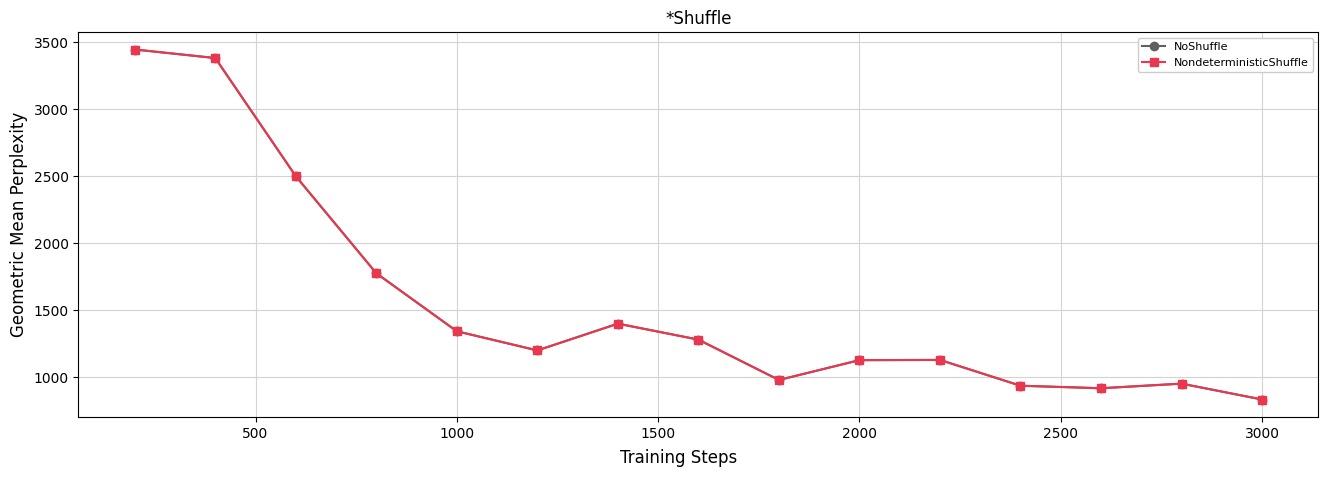

In [ ]:
import re

MAX_TRAINING_STEPS = 3000
CHECKPOINTS = list(range(200, MAX_TRAINING_STEPS+1, 200))
SEEDS = [41] #[0, 14, 41, 53, 96]


shuffle_file_info = [
    ("shuffle_control", "shuffle_control", 'o', "-", 'NoShuffle'),
    ("shuffle_nondeterministic", "shuffle_nondeterministic", "s", "-", 'NondeterministicShuffle'),
    ("shuffle_deterministic21", "shuffle_deterministic21", "v", "-", 'DeterministicShuffle$(s=21)$'),
    # ("shuffle_deterministic57", "shuffle_deterministic57", "v", ":", 'DeterministicShuffle$(s=57)$'),
    # ("shuffle_deterministic84", "shuffle_deterministic84", "v", "--", 'DeterministicShuffle$(s=84)$'),
    # ("shuffle_local3", "shuffle_local3", "^", "-", 'LocalShuffle$(w=3)$'),
    # ("shuffle_local5", "shuffle_local5", "^", ":", 'LocalShuffle$(w=5)$'),
    # ("shuffle_local10", "shuffle_local10", "^", "--", 'LocalShuffle$(w=10)$'),
    # ("shuffle_even_odd", "shuffle_even_odd", "d", "-", 'EvenOddShuffle'),
]
reverse_file_info = [
    ("reverse_control", "reverse_control", 'o', "-", 'NoReverse'),
    ("reverse_partial", "reverse_partial", "s", "-", 'PartialReverse'),
    ("reverse_full", "reverse_full", 'v', "-", 'FullReverse'),
]
hop_file_info = [
    ("hop_control", "hop_control", 'o', "-", 'NoHop'),
    ("hop_tokens4", "hop_tokens4", "s", "-", 'TokenHop'),
    ("hop_words4", "hop_words4", 'v', "-", 'WordHop'),
]

# Plot
plot_perplexities_grouped([shuffle_file_info], #, reverse_file_info, hop_file_info], 
                          ["*Shuffle"], #, "*Reverse", "*Hop"],
                          CHECKPOINTS, SEEDS)
plt.savefig("figures/perplexities.pdf", format="pdf", bbox_inches="tight")

# # No Pos Encodings
# plot_perplexities_grouped([shuffle_file_info, reverse_file_info, hop_file_info], 
#                           ["*Shuffle", "*Reverse", "*Hop"],
#                           CHECKPOINTS, [53], pos_encodings=False)
# plt.savefig("figures/perplexities_no_pos_encodings.pdf", format="pdf", bbox_inches="tight")

In [ ]:
csv_path = "/home/s2678328/perplexity_results/shuffle_control_100M/randinit_seed41_test_shuffle_control.csv"
fig, ax = plot_single_file_perplexity(csv_path)
plt.savefig("figures/single_file_perplexity.pdf", format="pdf", bbox_inches="tight")

NameError: name 'plot_single_file_perplexity' is not defined

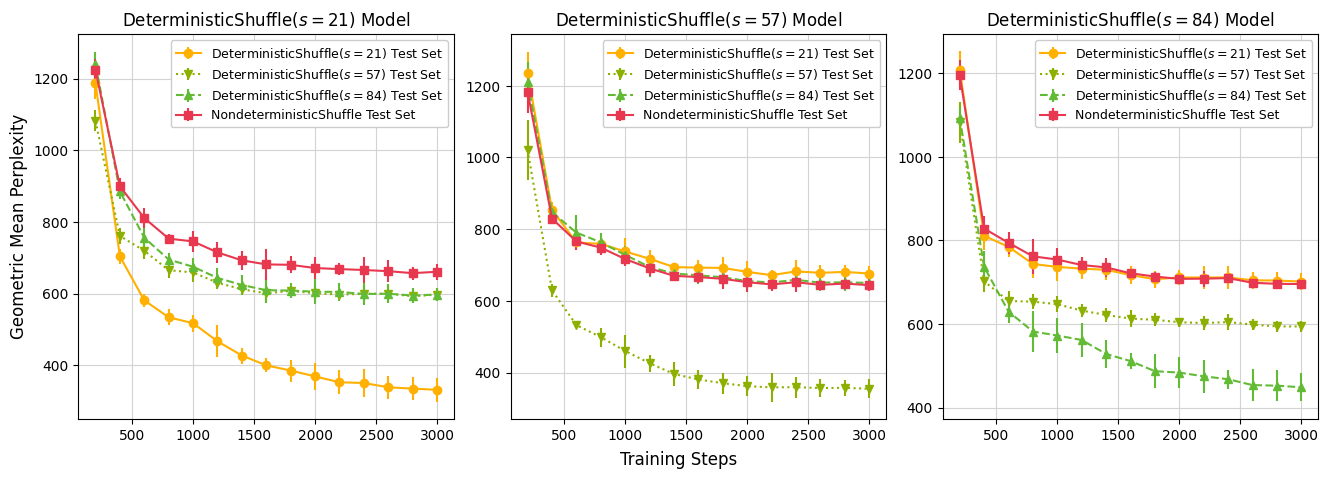

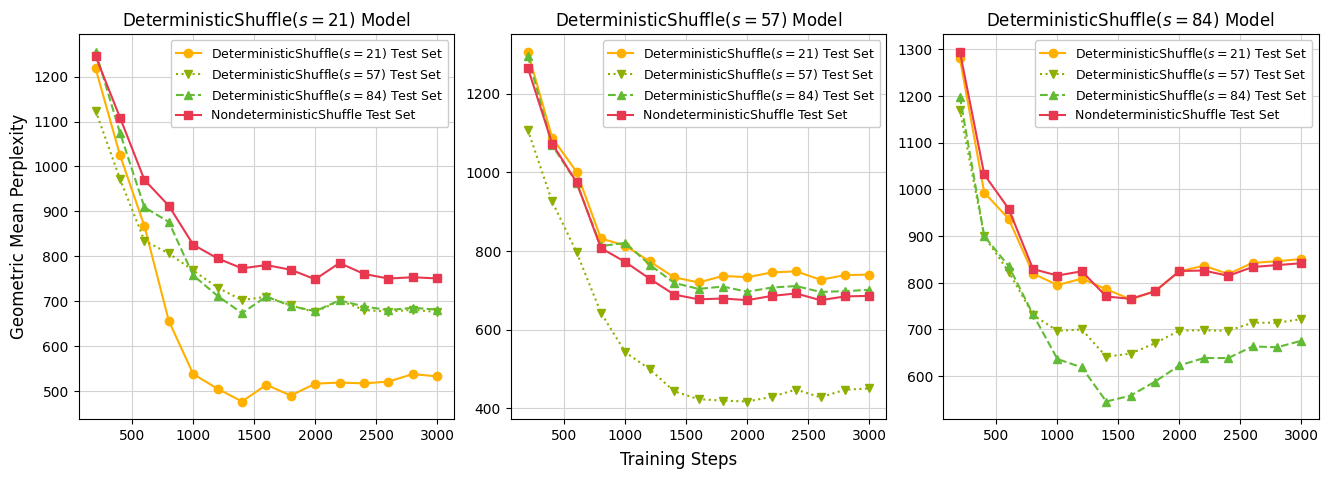

In [ ]:
shuffle21_file_info = [
    ("shuffle_deterministic21", "shuffle_deterministic21", "o", "-", 'DeterministicShuffle$(s=21)$ Test Set'),
    ("shuffle_deterministic21", "shuffle_deterministic57", "v", ":", 'DeterministicShuffle$(s=57)$ Test Set'),
    ("shuffle_deterministic21", "shuffle_deterministic84", "^", "--", 'DeterministicShuffle$(s=84)$ Test Set'),
    ("shuffle_deterministic21", "shuffle_nondeterministic", "s", "-", 'NondeterministicShuffle Test Set'),
]
shuffle57_file_info = [
    ("shuffle_deterministic57", "shuffle_deterministic21", "o", "-", 'DeterministicShuffle$(s=21)$ Test Set'),
    ("shuffle_deterministic57", "shuffle_deterministic57", "v", ":", 'DeterministicShuffle$(s=57)$ Test Set'),
    ("shuffle_deterministic57", "shuffle_deterministic84", "^", "--", 'DeterministicShuffle$(s=84)$ Test Set'),
    ("shuffle_deterministic57", "shuffle_nondeterministic", "s", "-", 'NondeterministicShuffle Test Set'),
]
shuffle84_file_info = [
    ("shuffle_deterministic84", "shuffle_deterministic21", "o", "-", 'DeterministicShuffle$(s=21)$ Test Set'),
    ("shuffle_deterministic84", "shuffle_deterministic57", "v", ":", 'DeterministicShuffle$(s=57)$ Test Set'),
    ("shuffle_deterministic84", "shuffle_deterministic84", "^", "--", 'DeterministicShuffle$(s=84)$ Test Set'),
    ("shuffle_deterministic84", "shuffle_nondeterministic", "s", "-", 'NondeterministicShuffle Test Set'),
]

# Plot
plot_perplexities_grouped([shuffle21_file_info, shuffle57_file_info, shuffle84_file_info], 
                          ["DeterministicShuffle$(s=21)$ Model", "DeterministicShuffle$(s=57)$ Model",
                           "DeterministicShuffle$(s=84)$ Model"],
                          CHECKPOINTS, SEEDS)
plt.savefig("figures/perplexities_deterministic_shuffle.pdf", format="pdf", bbox_inches="tight")

# No Pos Encodings
plot_perplexities_grouped([shuffle21_file_info, shuffle57_file_info, shuffle84_file_info], 
                          ["DeterministicShuffle$(s=21)$ Model", "DeterministicShuffle$(s=57)$ Model",
                           "DeterministicShuffle$(s=84)$ Model"],
                          CHECKPOINTS, [53], pos_encodings=False)
plt.savefig("figures/perplexities_deterministic_shuffle_no_pos_encodings.pdf", format="pdf", bbox_inches="tight")

In [44]:
# def plot_single_file_perplexity(csv_path, label=""):
#     import pandas as pd
#     import matplotlib.pyplot as plt
#     from scipy import stats
#     import numpy as np

#     df = pd.read_csv(csv_path)

#     # Strip column names to ensure matching
#     df.columns = [col.strip() for col in df.columns]
#     # display (df)
#     df.columns = df.columns.str.strip()  # ← IMPORTANT FIX
    
#     print("Available columns:", df.columns.tolist())
#     # Filter only checkpoint columns
#     ckpt_cols = [col for col in df.columns if "Perplexities (ckpt" in col]
#     ckpt_nums = [int(col.split("ckpt")[1].strip(" )")) for col in ckpt_cols]
#     print (ckpt_cols)
#     print (ckpt_nums)
    
#     # Compute geometric mean
#     gmeans = [stats.gmean(df[col]) for col in ckpt_cols]
#     print (gmeans)

#     # Sort by checkpoint
#     ckpt_gmeans = sorted(zip(ckpt_nums, gmeans), key=lambda x: x[0])
#     x, y = zip(*ckpt_gmeans)

#     fig, ax = plt.subplots(figsize=(6, 4))
#     ax.plot(x, y, marker="o", label=label)
#     ax.set_xlabel("Checkpoint")
#     ax.set_ylabel("Perplexity")
#     ax.set_title("Geometric Mean Perplexity")
#     ax.grid(True)
#     ax.legend()
#     return fig, ax

def plot_single_file_perplexity(csv_path, label="Model"):
    import pandas as pd
    import matplotlib.pyplot as plt
    import scipy.stats as stats
    import re

    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()

    checkpoints = []
    gmeans = []

    for col in df.columns:
        match = re.search(r'ckpt\s*(\d+)', col)
        if match:
            ckpt = int(match.group(1))
            checkpoints.append(ckpt)

            values = pd.to_numeric(df[col], errors='coerce')
            values = values[values > 0]
            gmeans.append(stats.gmean(values))

    if not gmeans:
        print("⚠️ No valid gmean values found!")
        return

    checkpoints, gmeans = zip(*sorted(zip(checkpoints, gmeans)))

    print("checkpoints:", checkpoints)
    print("gmeans:", gmeans)

    fig, ax = plt.subplots()
    ax.plot(checkpoints, gmeans, marker='o', label=label)
    ax.set_title("Geometric Mean Perplexity")
    ax.set_xlabel("Checkpoint")
    ax.set_ylabel("Perplexity")
    ax.grid(True)
    ax.legend()
    return fig, ax

checkpoints: (100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000)
gmeans: (11112362.740590341, 3443.211619326502, 6273.7036999923985, 3379.479737951279, 3299.018273248347, 2498.729678766878, 1800.5110017710635, 1775.3859866179473, 1664.1794010988433, 1343.1041659055352, 1352.4328167866204, 1200.3364694154104, 1702.9418390025849, 1399.9551777923953, 1611.7435069496385, 1280.908466078864, 1442.1777951024162, 980.1575852778034, 1196.6942428735317, 1127.9553427762733, 1416.9980462955496, 1129.628886234383, 1333.4173817758299, 937.283515158615, 1322.4034647128474, 918.5014564407255, 1299.974996215167, 952.8814620098323, 955.1137032205395, 834.6490409562168)


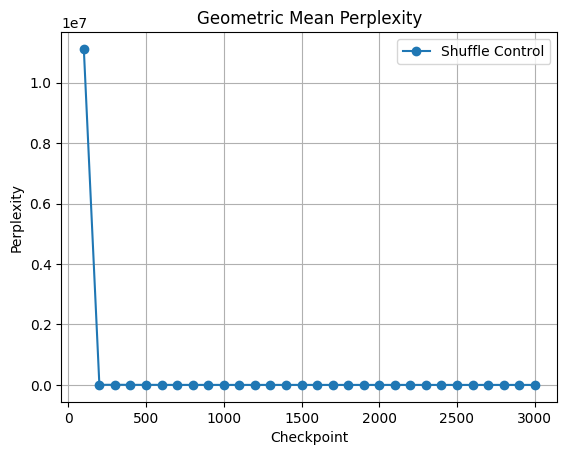

In [45]:
csv_path = "/home/s2678328/perplexity_results/shuffle_control_100M/randinit_seed41_test_shuffle_control.csv"
fig, ax = plot_single_file_perplexity(csv_path, label="Shuffle Control")
plt.savefig("figures/perplexity_shuffle_control.pdf", bbox_inches="tight")

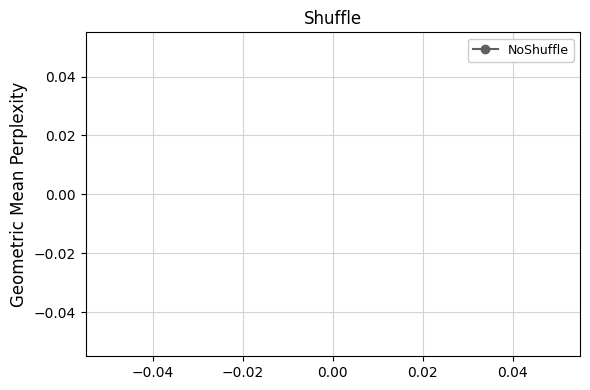

In [46]:
# import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 4))

plot_geometric_mean_perplexities(
    ax_i=0,
    ax=ax,
    file_info=[("shuffle_control", "shuffle_control", 'o', "-", 'NoShuffle')],
    title="Shuffle",
    checkpoints=CHECKPOINTS,
    seeds=[41],
    pos_encodings=True,
    warmup=False,
    csv_path="/home/s2678328/perplexity_results/shuffle_control_100M/randinit_seed41_test_shuffle_control.csv"
)

plt.tight_layout()
plt.savefig("perplexity_single_shuffle.pdf", format="pdf", bbox_inches="tight")

In [14]:
csv_path = "/home/s2678328/perplexity_results/shuffle_control_100M/randinit_seed41_test_shuffle_control.csv"
fig, ax = plot_single_file_perplexity(csv_path)
plt.savefig("figures/single_file_perplexity.pdf", format="pdf", bbox_inches="tight")

NameError: name 'plot_single_file_perplexity' is not defined

## Results with different warm-up hyperparameters

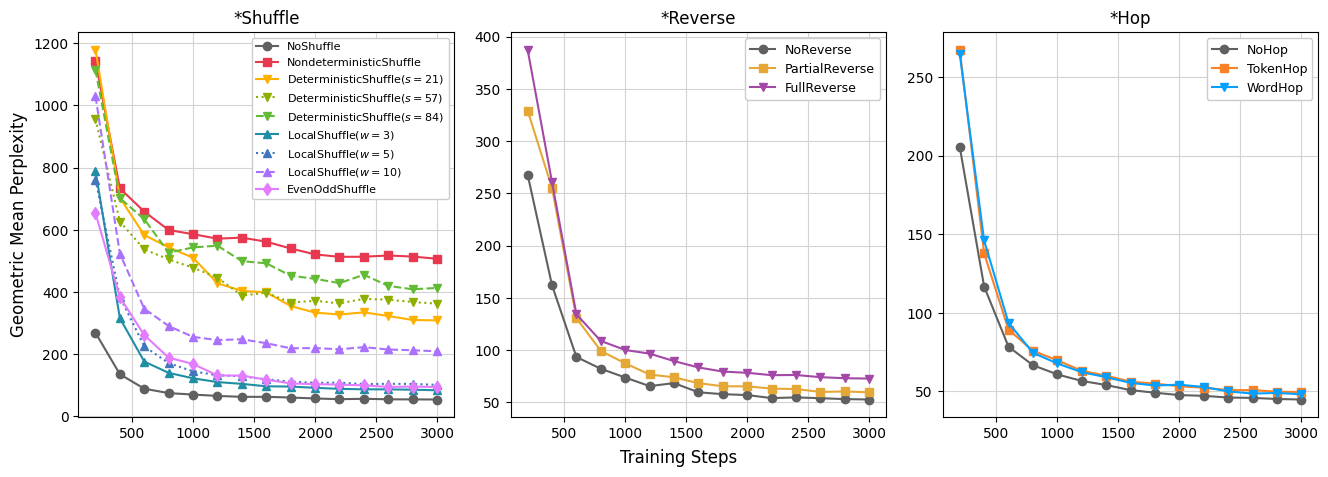

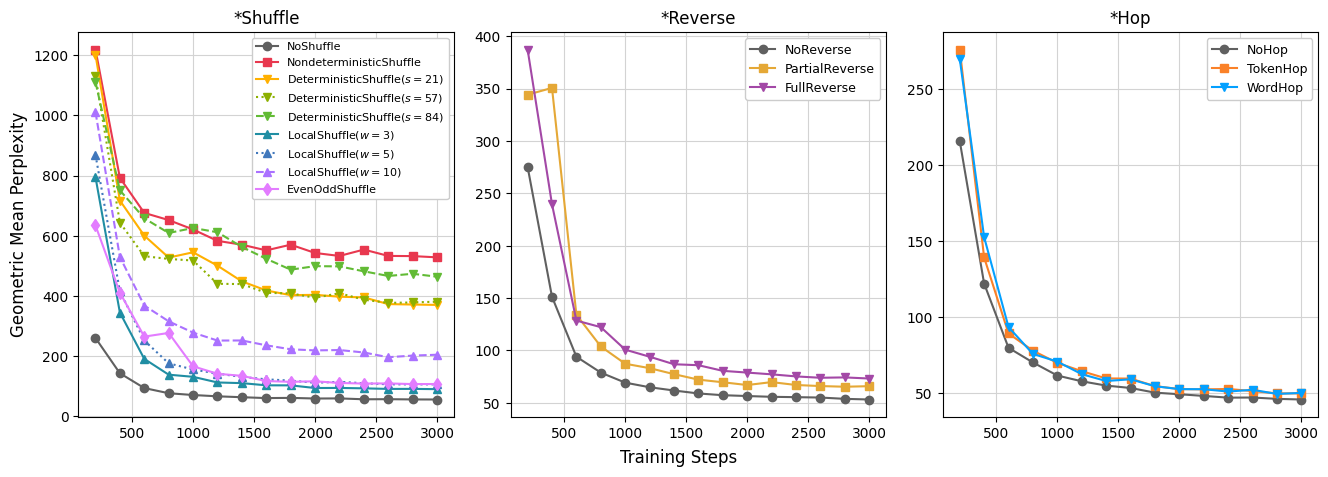

In [7]:
MAX_TRAINING_STEPS = 3000
CHECKPOINTS = list(range(200, MAX_TRAINING_STEPS+1, 200))


shuffle_file_info = [
    ("shuffle_control", "shuffle_control", 'o', "-", 'NoShuffle'),
    ("shuffle_nondeterministic", "shuffle_nondeterministic", "s", "-", 'NondeterministicShuffle'),
    ("shuffle_deterministic21", "shuffle_deterministic21", "v", "-", 'DeterministicShuffle$(s=21)$'),
    ("shuffle_deterministic57", "shuffle_deterministic57", "v", ":", 'DeterministicShuffle$(s=57)$'),
    ("shuffle_deterministic84", "shuffle_deterministic84", "v", "--", 'DeterministicShuffle$(s=84)$'),
    ("shuffle_local3", "shuffle_local3", "^", "-", 'LocalShuffle$(w=3)$'),
    ("shuffle_local5", "shuffle_local5", "^", ":", 'LocalShuffle$(w=5)$'),
    ("shuffle_local10", "shuffle_local10", "^", "--", 'LocalShuffle$(w=10)$'),
    ("shuffle_even_odd", "shuffle_even_odd", "d", "-", 'EvenOddShuffle'),
]
reverse_file_info = [
    ("reverse_control", "reverse_control", 'o', "-", 'NoReverse'),
    ("reverse_partial", "reverse_partial", "s", "-", 'PartialReverse'),
    ("reverse_full", "reverse_full", 'v', "-", 'FullReverse'),
]
hop_file_info = [
    ("hop_control", "hop_control", 'o', "-", 'NoHop'),
    ("hop_tokens4", "hop_tokens4", "s", "-", 'TokenHop'),
    ("hop_words4", "hop_words4", 'v', "-", 'WordHop'),
]

# Plot
plot_perplexities_grouped([shuffle_file_info, reverse_file_info, hop_file_info], 
                          ["*Shuffle", "*Reverse", "*Hop"],
                          CHECKPOINTS, [96])
plt.savefig("figures/perplexities_warmup1000.pdf", format="pdf", bbox_inches="tight")

plot_perplexities_grouped([shuffle_file_info, reverse_file_info, hop_file_info], 
                          ["*Shuffle", "*Reverse", "*Hop"],
                          CHECKPOINTS, [0])
plt.savefig("figures/perplexities_warmup4000.pdf", format="pdf", bbox_inches="tight")